# Random forest

## Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

## Data Loading
Loading and cleaning data

In [8]:
try:
    df = pd.read_csv('sms+spam+collection/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
except FileNotFoundError:
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# display the distribution of labels
print(f"Original distribution :\n{df['label'].value_counts(normalize=True)}")

# delete column 'label'
df = df.drop(columns=['label'])
print(df.head())

Original distribution :
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64
                                             message  label_num
0  Go until jurong point, crazy.. Available only ...          0
1                      Ok lar... Joking wif u oni...          0
2  Free entry in 2 a wkly comp to win FA Cup fina...          1
3  U dun say so early hor... U c already then say...          0
4  Nah I don't think he goes to usf, he lives aro...          0


## Visualization (Full Data)
PCA visualization of the entire dataset.

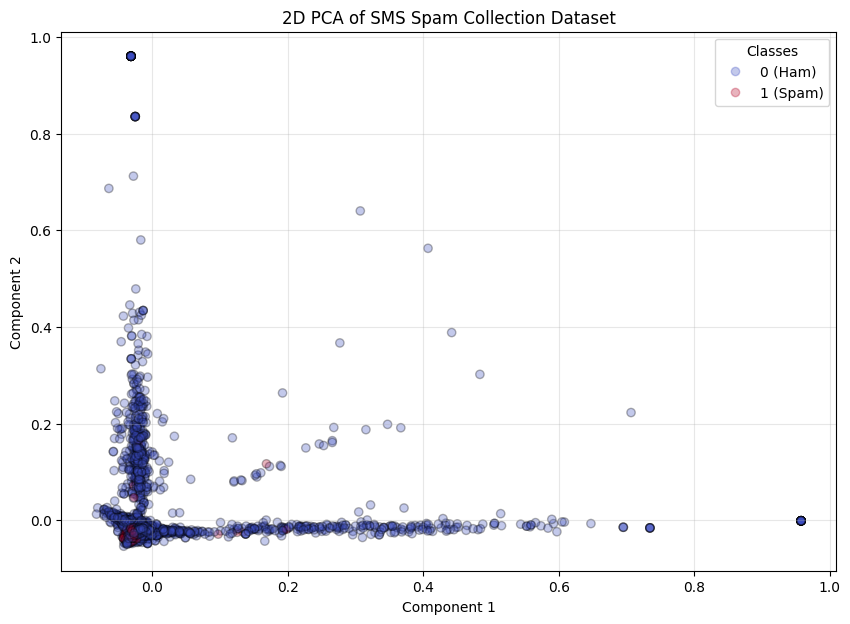

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['message'])
y = df['label_num']

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Chart
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], 
                      c=y, cmap='coolwarm', alpha=0.3, edgecolors='k')

# Legend
handles, _ = scatter.legend_elements()
plt.legend(handles, ['0 (Ham)', '1 (Spam)'], title="Classes")

plt.title('2D PCA of SMS Spam Collection Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, alpha=0.3)
plt.show() 

## Data preparation
### Data Splitting (Validation Set)
We isolate 20% of the data for the final test (sacred).

In [10]:
X_remaining, X_test, y_remaining, y_test = train_test_split(
    df['message'], df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

### Creating the Tiny Training Set
We only keep 40 examples for real-world training.

In [11]:
TRAIN_SIZE = 40 
X_train_real, _, y_train_real, _ = train_test_split(
    X_remaining, y_remaining, train_size=TRAIN_SIZE, random_state=42, stratify=y_remaining
)

print(f"Real Training Size: {len(X_train_real)}")
print(f"Test Set Size: {len(X_test)}")

Real Training Size: 40
Test Set Size: 1115


### Vectorization
We vectorize the 40 examples.

In [12]:
# Create Vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english')

# Fit on TRAIN, transform TEST
X_train_real_vec = vectorizer.fit_transform(X_train_real)
X_test_vec = vectorizer.transform(X_test)

### Plot trainning data

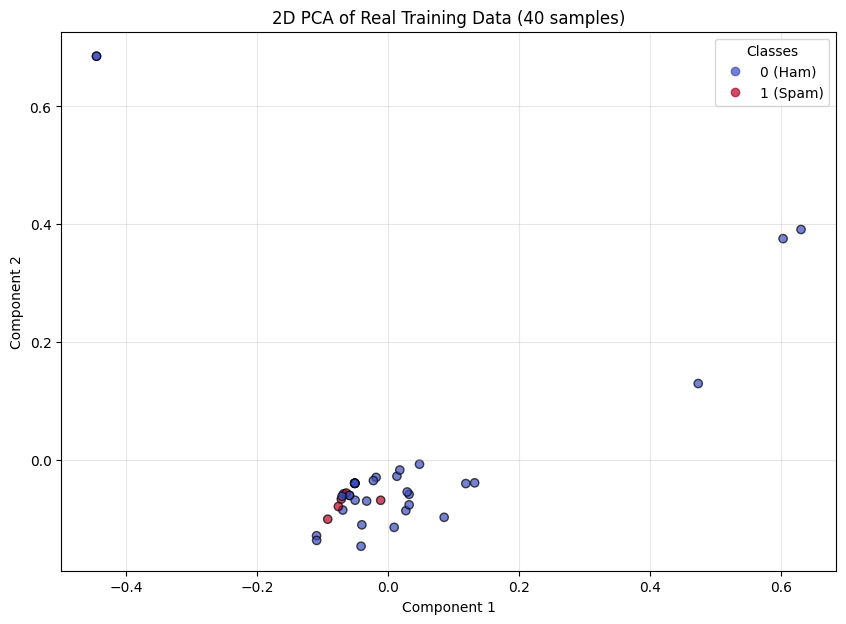

In [13]:
# PCA reduction to 2D
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X_train_real_vec.toarray())

# chart
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], 
                      c=y_train_real, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.title('2D PCA of Real Training Data (40 samples)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, alpha=0.3)

# legend
handles, _ = scatter.legend_elements()
plt.legend(handles, ['0 (Ham)', '1 (Spam)'], title="Classes")

# save chart
#plt.savefig("charts/resultat_reduced_data.png")

## Training models on real data.
### Baseline Random Forest

In [14]:
# train 
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_real_vec, y_train_real)
y_pred_rfc = rfc.predict(X_test_vec)

# metriques
print("--- Baseline Random Forest Results ---")
print(classification_report(y_test, y_pred_rfc))
print(f"MCC Score: {matthews_corrcoef(y_test, y_pred_rfc)}")

--- Baseline Random Forest Results ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

MCC Score: 0.0


/home/titmo/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/titmo/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/titmo/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

### Baseline SVM

In [15]:
svm = SVC(kernel='linear')
svm.fit(X_train_real_vec, y_train_real)
y_pred_svm = svm.predict(X_test_vec)

# metriques
print("--- Baseline SVM Results ---")
print(classification_report(y_test, y_pred_svm))
print(f"MCC Score: {matthews_corrcoef(y_test, y_pred_svm)}")

--- Baseline SVM Results ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       1.00      0.04      0.08       149

    accuracy                           0.87      1115
   macro avg       0.94      0.52      0.50      1115
weighted avg       0.89      0.87      0.82      1115

MCC Score: 0.18728598572773505


### Confusion Matrixs

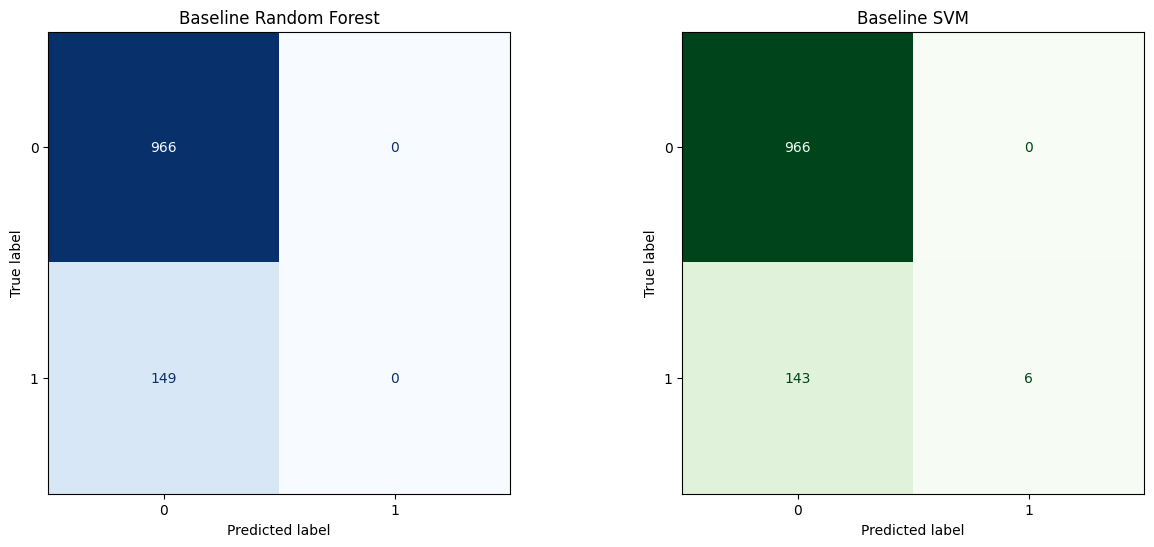

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title("Baseline Random Forest")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax[1], cmap='Greens', colorbar=False)
ax[1].set_title("Baseline SVM")
plt.show()

## Data Augmentation

In [17]:
# Example spam messages for data augmentation generate with Gemini
synthetic_spams = [
    "URGENT: You have an unclaimed PPI refund of £3,850 waiting for you! Reply CLAIM to 07890123456 immediately to verify your details.",
    "CONGRATS! You've been selected for a £1000 Tesco gift card. Press 1 or go to http://www.winner-uk-prizes.com/claim now! Offer ends 2mrw.",
    "WARNING: We have detected unusual activity on your Santander account. Please log in at http://secure-santander-update.com to verify your identity.",
    "Hey hun, saw your profile online ;) I'm lonely tonight. Text CHAT to 69888 to connect with singles in your area. 18+ only. £1.50/msg.",
    "FINAL NOTICE: HMRC has issued a tax refund of £465.80. You must claim by Friday or funds will be returned. Visit http://hmrc-gov-refunds.co.uk",
    "You have won a FREE iPhone 15 Pro! Reply YES to +447700900123 to arrange delivery. T&Cs apply.",
    "Your package from Royal Mail is held at the depot due to unpaid shipping fee of £2.99. Pay now at: http://royal-mail-fee-pay.com to avoid return.",
    "LOAN APPROVED: You are eligible for an unsecured loan of up to £5000. No credit check required. Text CASH to 80099.",
    "Hi, is this John? I found your number in my old phone. Want to meet up? check my pics at http://bit.ly/sexy-pics-uk",
    "NATWEST ALERT: A new payee was added to your account on 26/12. If this wasn't you, click here immediately: http://natwest-security-check.net",
    "IMPORTANT: Our records show you were involved in a non-fault accident. You could be owed up to £2500. Reply CLAIM to proceed.",
    "PRIVATE! Your 2000 bonus points expire in 24 hours. Redeem for cash or vouchers at http://redeem-points-now.co.uk",
    "Someone special wants to meet you! Find out who it is by replying LOVE to 85555. texts cost £2.",
    "URGENT! Your mobile number was chosen as the WINNER of our daily lottery! Claim your £500,000 prize. Call 09066612345 NOW!",
    "Barclays: Your debit card starting 4855 has been temporarily suspended due to suspicious transaction. Reactivate: http://barclays-auth-id.com",
    "FREE ENTRY to our £200 weekly draw! Just text WIN to 82228. 16+ only. Help? 0800123456",
    "Reminder: You have a new voicemail from 07812345678. Listen now at http://vmail-box.co.uk/listen",
    "Hot local girls want to chat! Don't be shy. Text DATE to 66777. 1st msg FREE.",
    "AMAZON: Your order #445-1234 is pending delivery. confirm your address to receive it tomorrow: http://amzn-delivery-update.co.uk",
    "URGENT ALERT: Your energy bill is overdue by £145. Power will be disconnected in 24hrs. Pay here: http://british-gas-pay.com",
    "YOU WON! A holiday to Ibiza for 2 people is waiting for you! Call +447000123456 to book your dates.",
    "HSBC: Did you attempt a payment of £1200 to 'Argos'? Reply Y if yes or N if no. If N, follow link: http://hsbc-fraud-team.com",
    "LUCKY DAY! You have been selected for a £500 ASDA voucher. Click to claim: http://asda-rewards-uk.com",
    "Need cash fast? Get up to £1000 in your bank within 15 mins! Text LOAN to 88990. 1289% APR Rep.",
    "Hey! I saw you at the pub last night but was too shy to say hi. Text me back? xoxo 07999888777",
    "CRITICAL: We have been trying to contact you about your car insurance claim. You are due £1,230. Reply INFO now.",
    "Congratulations! Your mobile number won the UK Lotto. Prize: £1,000,000. Email claims@uk-lotto-winners.com with code UK55.",
    "DPD: We missed you today. Your parcel is at the depot. Reschedule delivery here: http://dpd-missed-parcel.com",
    "Last chance to claim your £150 Amazon Gift Card! Survey expires in 2 hours. Go to http://survey-rewards.co.uk",
    "HALIFAX SECURITY: Unusual login attempt from IP 192.168.0.1. Account locked. Unlock here: http://halifax-verify-user.com",
    "Are you single? Join the UK's hottest dating site for FREE today. Click http://uk-singles-meet.com",
    "YOU HAVE 1 NEW MESSAGE. A secret admirer left a recording. Call 09050001234 to listen. £1.50/min.",
    "URGENT: Your vehicle tax is expired. You will be fined £1000 if not paid by tomorrow. Renew at http://dvla-gov-tax.co.uk",
    "Mystery Shopper needed! Earn £300/week evaluating local shops. Apply now: http://mystery-jobs-uk.com",
    "Lloyds Bank: Payment to AIRBNB for £450.00 declined. If this was not you, visit http://lloyds-fraud-prevention.com",
    "Double your data for free! Offer ends midnight. Reply YES to activate. O2 Rewards.",
    "WINNER!! You have won a luxury cruise to the Caribbean! Text CRUISE to 80022 to claim. T&C Apply.",
    "Hi its Sarah. My phone broke so I'm using this number. Msg me back on WhatsApp +447555123456 urgent.",
    "Alert: You have been exposed to someone who tested positive for COVID-19. Order a test kit: http://nhs-test-trace-uk.com",
    "Exclusive deal! 70% off Ray-Ban sunglasses. Today only. Shop now: http://rayban-outlet-sale.co.uk",
    "WARNING: Your Apple ID has been locked due to security reasons. Verify your identity at http://apple-id-recover-uk.com",
    "Naughty girls waiting for your call... don't make them wait! Call 09099998888. £2/min.",
    "EE: Your bill for this month is £125.40. This is higher than usual. View details: http://my-ee-bill-check.com",
    "Did you have an accident that wasn't your fault? You could claim thousands! No win no fee. Text ACCIDENT to 77888.",
    "CONGRATS! You are the 1000th visitor! Claim your prize: iPad Air 2. Click http://apple-rewards.com",
    "Netflix: Your subscription payment failed. Update payment details to avoid suspension: http://netflix-account-update.com",
    "URGENT!!! Your bank account is frozen due to missing information. Visit your local branch or click http://bank-verify.co.uk",
    "Hot mums in your area want casual fun! No strings attached. Text MUM to 69000. 18+.",
    "SKY: Your broadband service will be terminated tomorrow due to non-payment. Pay £45.99 now: http://sky-bill-pay.com",
    "FINAL WARNING: You have 1 unclaimed reward of £500. It expires in 30 mins. Claim here: http://claim-funds-fast.co.uk"
]

synthetic_hams = [
    "Hey u coming to the library? im on the 3rd floor by the quiet zone.",
    "Starving rn. wanna grab lunch at the su in like 20 mins?",
    "did u finish the assignment for prof smith? im so confused lol",
    "Where r u?? lecture starts in 5 mins run!!",
    "meet me at starbucks b4 seminar, need coffee badly.",
    "Can i borrow ur notes from yesterday? i totally zoned out.",
    "im gonna be late, bus is taking forever. save me a seat pls.",
    "Are we still on for study group 2mrw or nah?",
    "Library is absolute chaos rn, no seats anywhere :/",
    "u wanna get pizza tonight? cba to cook.",
    "Just sent u the draft, let me know if it looks ok.",
    "omg i forgot we had a quiz today. im dead.",
    "Wait is the deadline tonight or 2mrw?? panic checking.",
    "Meeting sarah at the pub later if u wanna join.",
    "Done with class finally. u still on campus?",
    "Check ur email, the tutor just cancelled the 9am lecture!!!",
    "cant make it to lunch sorry, gotta finish this essay.",
    "Whats the room number again? im lost in the new building.",
    "bringing snacks to the library, text me if u want anything.",
    "seriously where are u guys? ive been waiting for 15 mins."
]

# Create synthetic dataframe
# Label 1 = Spam, Label 0 = Ham
df_synthetic = pd.DataFrame({
    'message': synthetic_spams + synthetic_hams,
    'label_num': [1] * len(synthetic_spams) + [0] * len(synthetic_hams)
})

print(f"Generated synthetic data size : {len(df_synthetic)}")

# Merge the datasets (Real Train + Synthetic)
X_train_aug = pd.concat([X_train_real, df_synthetic['message']])
y_train_aug = pd.concat([y_train_real, df_synthetic['label_num']])
print(f"New training set size : {len(X_train_aug)}")

Generated synthetic data size : 70
New training set size : 110


We vectorize new messages

In [18]:

vectorizer_aug = TfidfVectorizer(stop_words='english')
X_train_aug_vec = vectorizer_aug.fit_transform(X_train_aug)

# IMPORTANT : We transform X_test with this NEW vectorizer
X_test_aug_vec = vectorizer_aug.transform(X_test)


### Augmented Random Forest Training
Retraining the Random Forest on augmented data.

In [19]:
rfc_aug = RandomForestClassifier(n_estimators=100, random_state=42) 
rfc_aug.fit(X_train_aug_vec, y_train_aug)
y_pred_rfc_aug = rfc_aug.predict(X_test_aug_vec)

print("--- RESULTS WITH LLM AUGMENTATION (Random Forest) ---")
print(classification_report(y_test, y_pred_rfc_aug))
print(f"New MCC Score: {matthews_corrcoef(y_test, y_pred_rfc_aug)}")

--- RESULTS WITH LLM AUGMENTATION (Random Forest) ---
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       0.94      0.34      0.50       149

    accuracy                           0.91      1115
   macro avg       0.93      0.67      0.72      1115
weighted avg       0.91      0.91      0.89      1115

New MCC Score: 0.5316517884574503


### Augmented SVM Training
Retraining the SVM on augmented data.

In [20]:
svm_aug = SVC(kernel='linear')
svm_aug.fit(X_train_aug_vec, y_train_aug)
y_pred_svm_aug = svm_aug.predict(X_test_aug_vec)

print("--- RESULTS WITH LLM AUGMENTATION (Random Forest) ---")
print(classification_report(y_test, y_pred_svm_aug))
print(f"New MCC Score: {matthews_corrcoef(y_test, y_pred_svm_aug)}")

--- RESULTS WITH LLM AUGMENTATION (Random Forest) ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       966
           1       0.62      0.91      0.74       149

    accuracy                           0.91      1115
   macro avg       0.80      0.91      0.84      1115
weighted avg       0.94      0.91      0.92      1115

New MCC Score: 0.7060430306112683


### Confusion Matrixs with augmented data

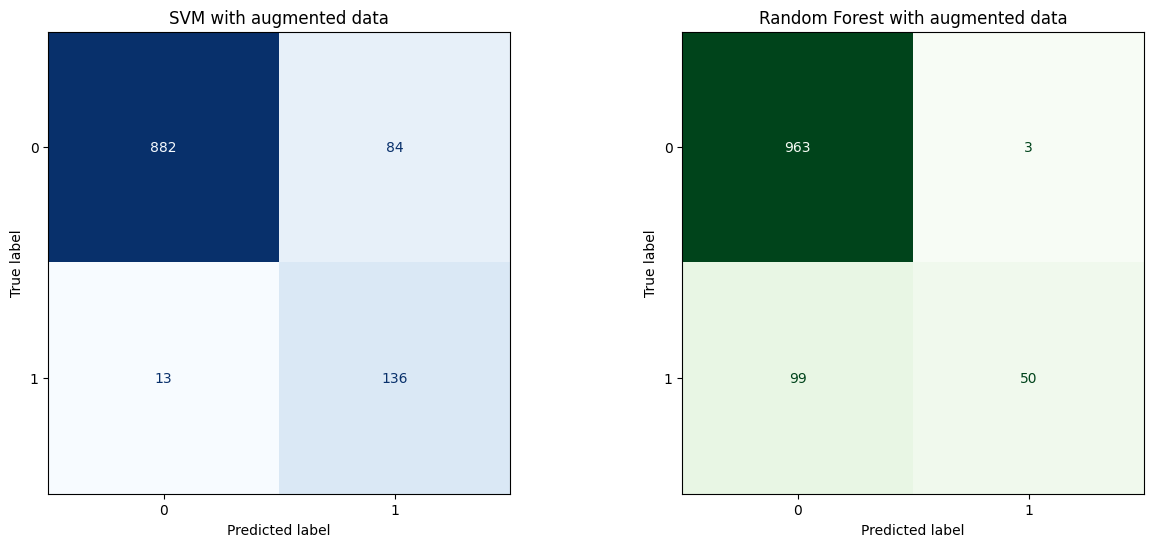

In [21]:
# Comparaison des matrices de confusion
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm_aug, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title("SVM with augmented data")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc_aug, ax=ax[1], cmap='Greens', colorbar=False)
ax[1].set_title("Random Forest with augmented data")
plt.show()